In [1]:
import json
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import umap

import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1234)

In [2]:
device = 'cpu'

In [3]:
### Paths ###
work_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
art_json = os.path.join(work_dir, 'Datateam/Artificial_imset/artificial_kymographs.json')
exp_json = os.path.join(work_dir, 'Datateam/imset1/experimental_kymograph.json')
models_folder = os.path.join(work_dir, 'DotsTorch/Trained_models/')

In [4]:
class ArtKymoDataset(Dataset):
     def __init__(self):
         # Data loading
         with open(art_json, 'r') as f:
             kymos = np.asarray(json.loads(f.read())["kymoset"])

         # Mean centering to match artificial data
         for i, kymo in enumerate(kymos):
             kymos[i] = (kymo - np.mean(kymo)) / np.std(kymo)

         smaller_extreme = np.min([np.abs(kymos.min()), np.abs(kymos.max())])
         kymos = np.clip(kymos, -smaller_extreme, smaller_extreme)

         print(kymos.max())

         kymos = kymos.astype('float32')

         kymos = torch.from_numpy(kymos)
         self.x = kymos
         self.x = self.x[:,None,:,:]
         self.n_samples = kymos.shape[0]

     def __getitem__(self, index):
         return self.x[index,:,:]

     def __len__(self):
         return self.n_samples

class ExpKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(exp_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read()))

        smaller_extreme = np.min([np.abs(kymos.min()), np.abs(kymos.max())])
        kymos = np.clip(kymos, -smaller_extreme, smaller_extreme)

        self.x = torch.from_numpy(kymos.astype('float32'))
        self.n_samples = kymos.shape[2]

    def __getitem__(self, index):
        return torch.unsqueeze(self.x[:,:,index], 0)

    def __len__(self):
        return self.n_samples

    def numpy(self):
        return self.x.numpy()

In [5]:
dataset = ArtKymoDataset()

6.452415177199512


In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, encoder, mu, logsigma, decoder):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = encoder
        self.mu = mu
        self.logsigma = logsigma
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

    def forward(self, x):
        h = self.encoder(x)
        mu, logsigma = self.mu(h), self.logsigma(h)

        # resample
        z = mu + torch.exp(logsigma) * torch.randn(mu.shape)

        return mu, logsigma, self.decoder(z)

    def embed(self, x):
        with torch.inference_mode():
            return self.mu(self.encoder(x))

    def loss(self, x, beta = 1):
        mu, logsigma, x_hat = self.forward(x)
        recon = self.mse_loss(x_hat, x)
        kl = torch.mean(0.5 * torch.sum(mu**2 + torch.exp(logsigma)**2 - 2 * logsigma - 1, dim=1))

        return recon + (beta * kl)

In [7]:
def train(dataloader, model, optimizer, beta = 1, device = 'cpu', report_interval = 50):
    """
    Adapted from https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#optimizing-the-model-parameters
    """
    size = len(dataloader.dataset)
    model.to(torch.device(device))
    model.train()

    for batch, X in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        loss = model.loss(X, beta=beta)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if report_interval is not None and batch % report_interval == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
model = VariationalAutoencoder(
    nn.Sequential(
        nn.Conv2d(1, 8, (3, 3), padding='same'),           # N x 8 x 20 x 60
        nn.Tanh(),
        nn.Conv2d(8, 8, (3, 3), stride=2, padding = 1),    # N x 8 x 10 x 30
        nn.Tanh(),

        nn.Conv2d(8, 16, (3, 3), padding='same'),          # N x 16 x 10 x 30
        nn.Tanh(),

        # nn.Conv2d(16, 16, (3, 3), padding='same'),          # N x 16 x 10 x 30
        # nn.Tanh(),

        # nn.Conv2d(16, 16, (3, 3), padding='same'),          # N x 16 x 10 x 30
        # nn.Tanh(),

        nn.Conv2d(16, 16, (3, 3), stride=2, padding = 1),  # N x 16 x 5 x 15
        nn.Tanh(),

        nn.Flatten()
    ),
    nn.Linear(1200, 256),  # mu
    nn.Linear(1200, 256),  # sigma
    nn.Sequential(
        nn.Linear(256, 1200),
        # nn.Unflatten(1, (1, 20, 60)),  # N x 1 x 20 x 60, let's be lazy
        # nn.Conv2d(1, 1, (3, 3), padding='same'),
        # nn.Conv2d(1, 1, (3, 3), padding='same'),
        # nn.ReLU()

        nn.Unflatten(1, (16, 5, 15)),

        # U-net style "up-conv"
        nn.Upsample(scale_factor=2, mode='bilinear'), # N x 16 x 10 x 30
        nn.Conv2d(16, 8, (3, 3), padding='same'),     # N x 8 x 20 x 30
        nn.Tanh(),

        # U-net style "up-conv"
        nn.Upsample(scale_factor=2, mode='bilinear'), # N x 8 x 20 x 60
        nn.Conv2d(8, 1, (3, 3), padding='same'),      # N x 1 x 20 x 60
        nn.Tanh(),
    )
)

In [9]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# plot the first two latent dimensions of the encoded kymographs
def plot_latent(model, data, dims=None):
    embeddings = np.zeros((256, len(dataset)))

    with torch.inference_mode():
        for (i, x) in enumerate(data):
            z = model.embed(x.unsqueeze(0).to(device))
            embeddings[:, i] = z.detach().to('cpu').numpy().squeeze()

    if dims is not None and isinstance(dims, list):
        plt.scatter(embeddings[dims[0], :], embeddings[dims[1], :], c='r', alpha = 0.3)

        plt.xlabel(f'Latent Dim {dims[0]}')
        plt.ylabel(f'Latent Dim {dims[1]}')
        plt.legend(loc='upper right')
        plt.title('Kymograph position in Latent Space')
        plt.legend
    else:
        reducer = umap.UMAP(random_state=42)
        reducer.fit(embeddings)
        u = reducer.fit_transform(embeddings)

        plt.scatter(u[:, 0], u[:, 1])
        plt.xlabel("U1")
        plt.ylabel("U2")


#pick random kymographs to reconstruct and show
def plot_sample_im(model, data):
    plt.figure(figsize=(12,5))

    idx = np.random.randint(len(dataset), size=3)

    for i, id in enumerate(idx):
        x = data[id]

        with torch.inference_mode():
            _, _, x_hat = model(x.unsqueeze(0).to(device))
            x_hat = x_hat.detach().to('cpu').numpy()

        plt.subplot(2,3,i+1)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Actual Kymographs")
        plt.imshow(x.squeeze(), cmap='gray')

        plt.subplot(2,3,i+4)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Reconstructed Kymographs")
        plt.imshow(x_hat.squeeze(), cmap='gray')

    plt.tight_layout()
    plt.show()

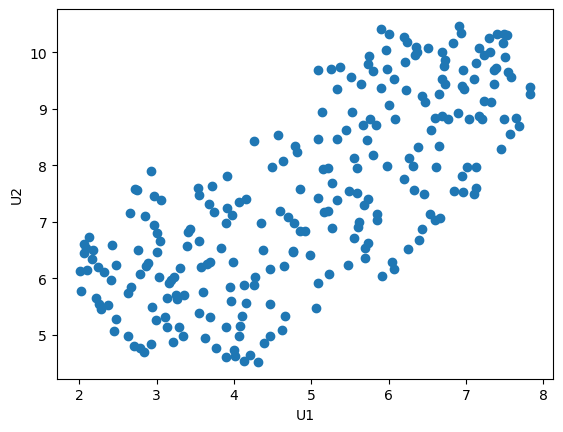

In [16]:
plot_latent(model, dataset, dims=None)

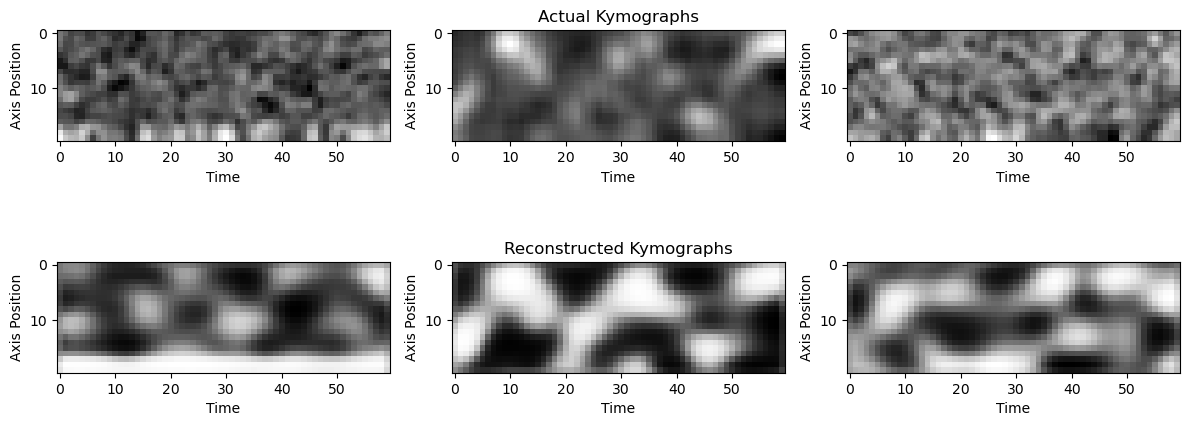

In [17]:
plot_sample_im(model, dataset)

In [18]:
import seaborn as sns
from string import ascii_lowercase
import matplotlib
#import svgutils.transform as st
from matplotlib import gridspec, pyplot as plt

matplotlib.rcParams["legend.labelspacing"] = 0.2
matplotlib.rcParams["legend.fontsize"] = 8
matplotlib.rcParams["xtick.major.pad"] = 1.0
matplotlib.rcParams["ytick.major.pad"] = 1.0
matplotlib.rcParams["xtick.minor.pad"] = 0.9
matplotlib.rcParams["ytick.minor.pad"] = 0.9
matplotlib.rcParams["legend.handletextpad"] = 0.5
matplotlib.rcParams["legend.handlelength"] = 0.5
matplotlib.rcParams["legend.framealpha"] = 0.5
matplotlib.rcParams["legend.markerscale"] = 0.7
matplotlib.rcParams["legend.borderpad"] = 0.35

def getSetup(figsize, gridd, multz=None, empts=None):
    """ Establish figure set-up with subplots. """
    sns.set(style="whitegrid", font_scale=0.7, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

    # create empty list if empts isn't specified
    if empts is None:
        empts = []

    if multz is None:
        multz = dict()

    # Setup plotting space and grid
    f = plt.figure(figsize=figsize, constrained_layout=True)
    gs1 = gridspec.GridSpec(*gridd, figure=f)

    # Get list of axis objects
    x = 0
    ax = list()
    while x < gridd[0] * gridd[1]:
        if x not in empts and x not in multz.keys():  # If this is just a normal subplot
            ax.append(f.add_subplot(gs1[x]))
        elif x in multz.keys():  # If this is a subplot that spans grid elements
            ax.append(f.add_subplot(gs1[x: x + multz[x] + 1]))
            x += multz[x]
        x += 1

    return (ax, f)


def subplotLabel(axs):
    """ Place subplot labels on figure. """
    for ii, ax in enumerate(axs):
        ax.text(-0.2, 1.2, ascii_lowercase[ii], transform=ax.transAxes, fontsize=16, fontweight="bold", va="top")

In [47]:
def plot_latent_w_reduction(ax1, ax2, autoencoder, data, trans_data, dims=[0,1]):
   
    assert len(dims) == 2
    
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        centroids = np.zeros((3, 2))
        if i < 99:
            ax1.scatter(z[dims[0]], z[dims[1]], c='darkorchid', s=12, label = ('Oscillatory' if i == 1 else None))
            ax2.scatter(trans_data[i, 0], trans_data[i, 1], c='darkorchid', s=12, label = ('Oscillatory' if i == 1 else None))
            centroids[0, :] = [centroids[0, 0]+trans_data[i, 0], centroids[0, 1]+trans_data[i, 1]]
        elif i < 199:
            ax1.scatter(z[dims[0]], z[dims[1]], c='crimson', s=12, label = ('Polar' if i == 101 else None))
            ax2.scatter(trans_data[i, 0], trans_data[i, 1], c='crimson', s=12, label = ('Polar' if i == 101 else None))
        else:
            ax1.scatter(z[dims[0]], z[dims[1]], c='c', s=12, label = ('Negative' if i == 201 else None))
            ax2.scatter(trans_data[i, 0], trans_data[i, 1], c='c', s=12, label = ('Negative' if i == 201 else None))
        #ax1.scatter(z[dims[0]], z[dims[1]], s=12)
        #ax2.scatter(trans_data[i, 0], trans_data[i, 1], s=12)
        if (i%2 == 0):
            #ax2.text(trans_data[i, 0], trans_data[i, 1], i)
            pass


    ax1.set_xlabel('Latent Dim {}'.format(dims[0]+1), fontsize = 11)
    ax1.set_ylabel('Latent Dim {}'.format(dims[1]+1), fontsize = 11)
    ax1.set_title('Kymograph Position in Latent Space', fontsize = 14)
    ax1.legend()

    ax2.set_xlabel('UMAP Dim 1', fontsize = 11)
    ax2.set_ylabel('UMAP Dim 2', fontsize = 11)
    ax2.set_title('UMAP Dimensionality Reduction of Latent Space', fontsize = 14)
    ax2.legend()

    #centroids = centroids / 100
    print(centroids)

[[0. 0.]
 [0. 0.]
 [0. 0.]]


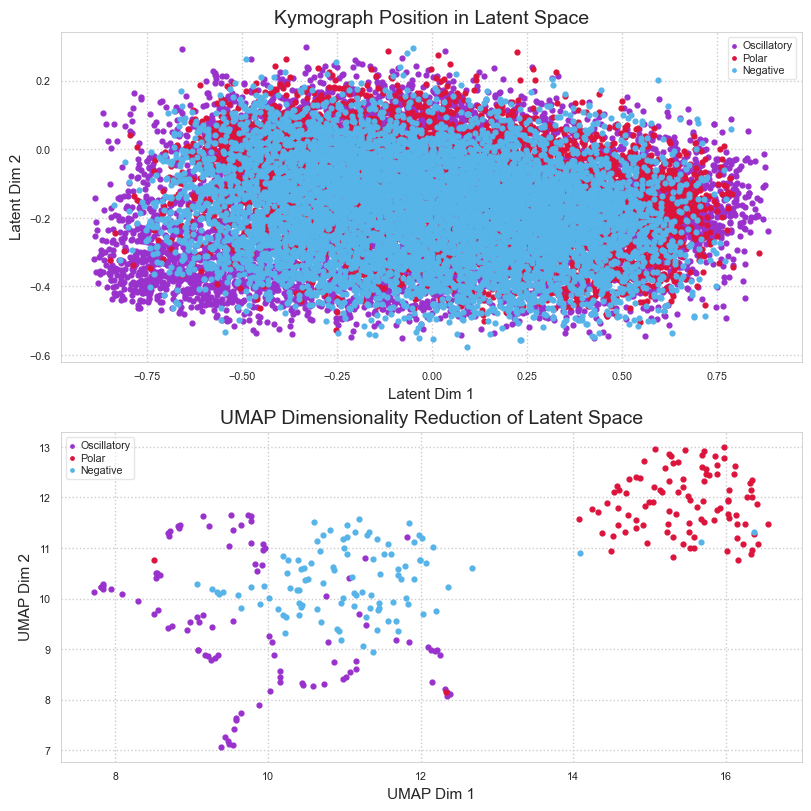

In [48]:
from umap import UMAP

X = np.zeros((256, len(dataset)))

with torch.inference_mode():
    for (i, x) in enumerate(dataset):
        z = model.embed(x.unsqueeze(0).to(device))
        X[:, i] = z.detach().to('cpu').numpy().squeeze()

reducer = UMAP(n_components=2)
X = np.transpose(X)
X_trans = reducer.fit_transform(X)

ax, f = getSetup((8, 8), (2, 1))

plot_latent_w_reduction(ax[0], ax[1], model, dataset, X_trans) 

In [26]:
def plot_index(index, data):
    plt.figure(figsize=(10,4))

    x = data[index]
        
    plt.xlabel('Time')
    plt.ylabel('Axis Position')
    plt.title("Kymograph {}".format(index))
    plt.imshow(x.squeeze(), cmap='gray')

    plt.tight_layout()
    plt.show()

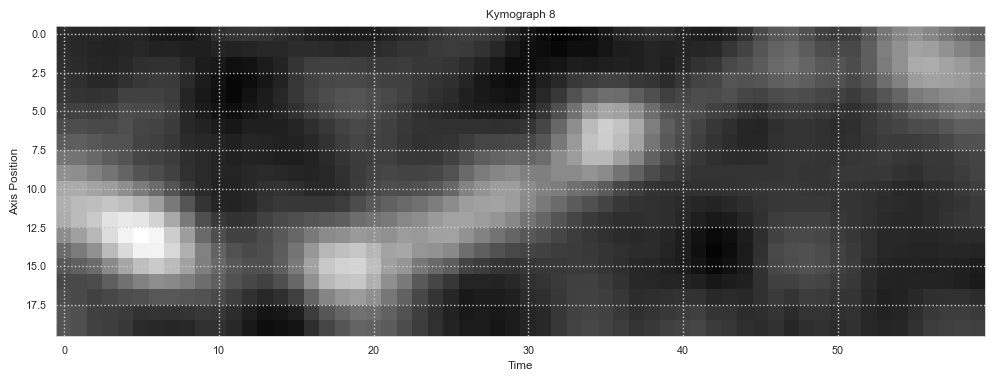

In [37]:
plot_index(8, dataset)